# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Normalizing-flow-in-PyMC3" data-toc-modified-id="Normalizing-flow-in-PyMC3-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Normalizing flow in PyMC3</a></div><div class="lev2 toc-item"><a href="#Limitation-of-meanfield-ADVI" data-toc-modified-id="Limitation-of-meanfield-ADVI-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Limitation of meanfield ADVI</a></div><div class="lev2 toc-item"><a href="#A-beta-binomial-model-for-overdispersion" data-toc-modified-id="A-beta-binomial-model-for-overdispersion-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>A beta-binomial model for overdispersion</a></div><div class="lev3 toc-item"><a href="#MCMC" data-toc-modified-id="MCMC-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>MCMC</a></div><div class="lev3 toc-item"><a href="#Gaussian-meanfield-ADVI" data-toc-modified-id="Gaussian-meanfield-ADVI-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Gaussian meanfield ADVI</a></div><div class="lev2 toc-item"><a href="#Normalizing-flow" data-toc-modified-id="Normalizing-flow-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Normalizing flow</a></div><div class="lev3 toc-item"><a href="#Interface" data-toc-modified-id="Interface-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>Interface</a></div><div class="lev3 toc-item"><a href="#Inverse-autoregressive-flow" data-toc-modified-id="Inverse-autoregressive-flow-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>Inverse autoregressive flow</a></div><div class="lev3 toc-item"><a href="#Masked-autoencoder-(MADE)" data-toc-modified-id="Masked-autoencoder-(MADE)-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>Masked autoencoder (MADE)</a></div><div class="lev3 toc-item"><a href="#Test-logdet-of-the-Jacobian-of-IAF" data-toc-modified-id="Test-logdet-of-the-Jacobian-of-IAF-1.3.4"><span class="toc-item-num">1.3.4&nbsp;&nbsp;</span>Test logdet of the Jacobian of IAF</a></div><div class="lev3 toc-item"><a href="#ADVI-with-IAF" data-toc-modified-id="ADVI-with-IAF-1.3.5"><span class="toc-item-num">1.3.5&nbsp;&nbsp;</span>ADVI with IAF</a></div><div class="lev2 toc-item"><a href="#References" data-toc-modified-id="References-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>References</a></div>

# Normalizing flow in PyMC3

In [1]:
%autosave 0
%matplotlib inline
import sys, os
sys.path.insert(0, os.path.expanduser('~/Code/pymc3'))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions.discrete import BetaBinomial
import seaborn as sns
from theano import config, shared, function
from theano.gradient import jacobian
import theano.tensor as tt

config.floatX = 'float32'

Autosave disabled


## Limitation of meanfield ADVI

## A beta-binomial model for overdispersion

In [2]:
def get_model():
    # Data and model adapted from Albert (2009)
    data = np.array(
        [(0, 1083), (0, 855), (2, 3461), (0, 657), (1, 1208), 
         (1, 1025), (0, 527), (2, 1668), (1, 583), (3, 582), 
         (0, 917), (1, 857), (1, 680), (1, 917), (54, 53637),
         (0, 874), (0, 395), (1, 581), (3, 588), (0, 383)]
    )
    xs, ns = data[:, 0], data[:, 1]

    with pm.Model() as model:
        def logp(mk):
            m = tt.nnet.sigmoid(mk[0])
            k = tt.exp(mk[1])
            return -1 * (tt.log(m) + tt.log(1 - m) + 2 * tt.log(1 + k))

        # Prior
        mk = pm.DensityDist('mk', logp, shape=(2,), testval=np.array([0.1, 0.1]).astype('float32'))

        # Reparametrization for beta-binomial distribution
        m = tt.nnet.sigmoid(mk[0])
        k = tt.exp(mk[1])
        alpha = k * m
        beta = k * (1 - m)
        
        # Likelihood
        BetaBinomial('x', alpha=alpha, beta=beta, n=ns, observed=xs)
        
    return model

In [3]:
def plot_samples(trace):
    m = trace['mk'][1000:, 0]
    k = trace['mk'][1000:, 1]
    df = pd.DataFrame({'logit m': m, 'log k': k})
    sns.jointplot(x="logit m", y="log k", data=df, xlim=[-7.7, -5.5], ylim=[4, 11])

### MCMC

100%|██████████| 11000/11000 [00:11<00:00, 954.14it/s]


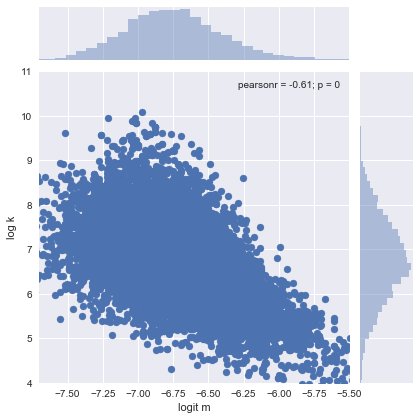

In [4]:
with get_model() as model:
    step = pm.NUTS()
    trace = pm.sample(11000, step=step)
    
plot_samples(trace)

### Gaussian meanfield ADVI

/Users/peadarcoyle/anaconda/envs/pymc3_dev/lib/python3.5/site-packages/Theano-0.8.2-py3.5.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Iteration 0 [0%]: ELBO = -95.63
Iteration 1000 [10%]: Average ELBO = -57.76
Iteration 2000 [20%]: Average ELBO = -48.27
Iteration 3000 [30%]: Average ELBO = -45.9
Iteration 4000 [40%]: Average ELBO = -43.39
Iteration 5000 [50%]: Average ELBO = -38.73
Iteration 6000 [60%]: Average ELBO = -36.57
Iteration 7000 [70%]: Average ELBO = -36.44
Iteration 8000 [80%]: Average ELBO = -36.57
Iteration 9000 [90%]: Average ELBO = -36.53
Finished [100%]: ELBO = -36.08


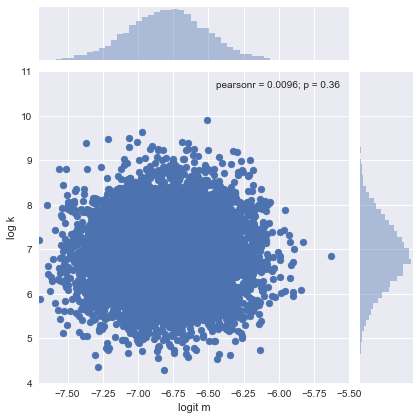

In [6]:
import lasagne
from collections import OrderedDict

adam = lambda loss, param: lasagne.updates.adam(loss, [param], learning_rate=0.01)

with get_model() as model:
    x = model.basic_RVs[1]
    vparams = pm.variational.advi_minibatch(n=10000, optimizer=adam, minibatch_tensors=[], minibatches=[], 
                                            observed_RVs=OrderedDict({x: 1}), local_RVs=OrderedDict())
    trace = pm.variational.sample_vp(vparams, 10000)
    
plot_samples(trace)

## Normalizing flow

### Interface

In [8]:
from abc import ABCMeta, abstractmethod

class NormalizingFlow:
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def init_model_params(self, d):
        """Initialize model parameters
        
        This method is called in ADVI inference functions, because 
        the dimension of parameter vector is difficult to know before 
        inference. 
        
        d : int
            Dimension of parameter vector.
        """
        pass
    
    @abstractmethod
    def trans(self, z_pre):
        """Transform variable (vector). """
        pass
    
    @abstractmethod
    def ldj(self, z_pre):
        """Returns logdet of Jacobian. """
        pass
    
    @abstractmethod
    def get_params(self):
        """Returns parameters. """
        pass

### Inverse autoregressive flow

In [9]:
class SimpleMadeIAF(NormalizingFlow):
    """An inverse autoregressive flow: (z - f1(z, h1, g1)) / f2(z, h2, g2)
    
    f[1/2] are MADEs, whose connectivity constraints are deterministically set. 
    h[1/2] are the activation functions of the hidden layers in f[1/2]. 
    g[1/2] are the activation functions of the output layers in f[1/2]. 
    The number of units in all layers are same with the dimension of the 
    random variable in ADVI. 
    
    Parameters
    ----------
    ns : list of int
        The numbers of units in all layers, shared for f1 and f2.
    hs : (tensor -> tensor, tensor -> tensor)
        Elementwise activation function of the hidden layers in f[1/2].
    gs : (tensor -> tensor, tensor -> tensor)
        Elementwise activation function of the output layer in f[1/2].
    rev_order : bool
        If true, the order of connectivity constraints is reversed.
    random_seed : int or None
        Random seed for initialization of weight matrices.

    Example
    -------
    ls = (1, 1)
    hs = (tt.nnet.sigmoid, tt.nnet.sigmoid)
    gs = ((lambda x: x), tt.nnet.softplus)
    SimpleMadeIAF(ls, hs, gs, 'upper')
    """
    def __init__(self, ns, hs, gs, rev_order=False, random_seed=None):
        self.ns = ns
        self.hs = hs
        self.gs = gs
        self.model_params = None
        self.rev_order = rev_order
        self.rng = np.random.RandomState(random_seed)
    
    def init_model_params(self, d):
        self.d = d
        w1s, b1s = _init_made_params([d] + self.ns + [d], self.rng) # f1
        w2s, b2s = _init_made_params([d] + self.ns + [d], self.rng) # f2
        self.wss = (w1s, w2s)
        self.bss = (b1s, b2s)
        self.model_params = w1s + w2s + b1s + b2s

        # Masks
        self.mask1s = _create_made_masks(self.d, self.ns, self.rev_order)
        self.mask2s = _create_made_masks(self.d, self.ns, self.rev_order)
        
    def trans(self, zs):
        """Transform random variables and compute log determinant of Jacobian.
        
        Parameters
        ----------
        zs : tensor, shape=(n_mc_samples, dim_rv)
            Random variables. n_mc_samples denotes the number of Monte Carlo samples
            in ADVI. dim_rv is the dimension of (concatenated) random variables. 
            
        Returns
        -------
        (zs_new, ldjs) : (tensor, tensor)
            Transformed random variables and log determinant of Jacobians.
            zs_new.shape is the same with zs. ldjs.shape = (n_mc_samples,). 
        """
        # Outputs of MADEs
        n_layers = len(self.ns)
        h1, h2 = self.hs
        g1, g2 = self.gs
        w1s, w2s = self.wss
        b1s, b2s = self.bss
        
        def f(zs, n_layers, h, g, ws, bs, masks):
            """MADE"""
            xs = zs
            for l in range(n_layers):
                xs = h(xs.dot(masks[l] * ws[l]) + bs[l])
            return g(xs.dot(masks[n_layers] * ws[n_layers]) + bs[n_layers])
        
        f1s = f(zs, n_layers, h1, g1, w1s, b1s, self.mask1s)
        f2s = f(zs, n_layers, h2, g2, w2s, b2s, self.mask2s)
        
        # Outputs
        zs_new = (zs - f1s) / f2s
        
        # Log determinant of Jacobian
        ldjs = -tt.sum(tt.log(f2s), axis=-1)
        
        return zs_new, ldjs
        
    def get_params(self):
        if self.model_params is None:
            raise RuntimeError("get_params() was invoked before trans().")
        else:
            return self.model_params

### Masked autoencoder (MADE)

In [10]:
def _init_made_params(ns, rng):
    """Initialize model parameters of a MADE.
    
    Parameters
    ----------
    l : int
        The numbers of units in all layers, 
        including the input and output layers.
    rng : numpy.random.RandomState
        Random number generator.
    
    Returns
    -------
    (ws, bs) : (List[shared], List[shared])
        Model parameters (weights and biases).
    """
    ws = list()
    bs = list()
    for l in range(len(ns) - 1):
        d_in = ns[l]
        d_out = ns[l + 1]
        ws.append(shared(0.01 * rng.randn(d_in, d_out).astype('float32')))
        bs.append(shared(0.01 * rng.randn(d_out).astype('float32')))

    return ws, bs


def _create_made_mask(d_pre, d, m_pre, output_layer, rev_order=False):
    """Create a mask for MADE.
    
    Parameters
    ----------
    d_pre : int
        The number of rows in the weight matrix. 
    d : int
        The number of columns in the weight matrix. 
    m_pre : numpy.ndarray, shape=(d_pre,)
        The number of inputs to the units in the previous layer.
    output_layer : bool
        True for the output layer. 
    rev_order : bool
        If true, the order of connectivity constraints is reversed. 
        It is used only for the output layer. 
    
    Returns
    -------
    m, mask : (numpy.ndarray, numpy.ndarray)
        Mask indices and Mask.
    """
    d_input = np.max(m_pre)
    mask = np.zeros((d_pre, d)).astype('float32')
    
    if not output_layer:
        m = np.arange(1, d_input).astype(int)
        if len(m) < d:
            m = np.hstack((m, (d_input - 1) * np.ones(d - len(m))))
            
        for ix_col in range(d):
            ixs_row = np.where(m_pre <= m[ix_col])[0]
            (mask[:, ix_col])[ixs_row] = 1

    else:
        m = np.arange(1, d + 1)
        if rev_order:
            m = m[::-1]
        for ix_col in range(d):
            ixs_row = np.where(m_pre < m[ix_col])[0]
            mask[ixs_row, ix_col] = 1
            
    return m, mask


def _create_made_masks(d, ns, rev_order=False):
    """Create masks for all layers.
    
    Parameters
    ----------
    d : int
        Input dimension.
    ns : list of int
        The numbers of units in all hidden layers. 
    rev_order : bool
        If true, the order of connectivity constraints is reversed.
        
    Returns
    -------
    masks : List[numpy.ndarray]
        List of masks.
    """
    # The number of layers
    n_layers = len(ns)
    
    # Mask indices for the input layer
    m = np.arange(1, d + 1).astype(int)
    if rev_order:
        m = m[::-1]
    masks = list()
    
    d_pre = d
    for l, n in zip(range(n_layers), ns):
        m, mask = _create_made_mask(d_pre, n, m, output_layer=False)
        masks.append(mask)
        d_pre = n
    _, mask = _create_made_mask(d_pre, d, m, output_layer=True, 
                                rev_order=rev_order)

    masks.append(mask)
    
    return masks

### Test logdet of the Jacobian of IAF

In [11]:
def test_iaf_ldj(d=3, rev_order=True, random_seed=0):
    # Random vector
    z = tt.vector(dtype='float32')
    z.tag.test_value = np.ones(d).astype('float32')
    
    # Triangular MADE-IAF
    ns = [(d + 10)]
    hs = (tt.nnet.softplus, tt.nnet.softplus)
    gs = ((lambda x: x), tt.exp)
    iaf = SimpleMadeIAF(ns, hs, gs, rev_order, random_seed)
    iaf.init_model_params(d)
    z_trans, ldj = iaf.trans(z)
    
    # Exact computation
    j = jacobian(z_trans, z).reshape((d, d))
    ldj_true = tt.log(tt.nlinalg.det(tt.abs_(j)))
    
    f = function([z], [ldj, ldj_true])
    print(f(10 + np.arange(d).astype('float32')))
    
test_iaf_ldj(d=3, rev_order=False)
test_iaf_ldj(d=3, rev_order=True)
test_iaf_ldj(d=3, rev_order=False, random_seed=1)
test_iaf_ldj(d=3, rev_order=True, random_seed=1)
test_iaf_ldj(d=100, rev_order=False)

[array(0.03311258554458618, dtype=float32), array(0.03311264514923096, dtype=float32)]
[array(0.0650162324309349, dtype=float32), array(0.06501622498035431, dtype=float32)]
[array(0.0008600028231739998, dtype=float32), array(0.0008599635912105441, dtype=float32)]
[array(-0.018910568207502365, dtype=float32), array(-0.018910527229309082, dtype=float32)]
[array(0.9090602397918701, dtype=float32), array(0.9090602397918701, dtype=float32)]


### ADVI with IAF

Iteration 0 [0%]: ELBO = -61.43
Iteration 1000 [10%]: Average ELBO = -45.48
Iteration 2000 [20%]: Average ELBO = -36.52
Iteration 3000 [30%]: Average ELBO = -36.58
Iteration 4000 [40%]: Average ELBO = -36.44
Iteration 5000 [50%]: Average ELBO = -36.55
Iteration 6000 [60%]: Average ELBO = -36.51
Iteration 7000 [70%]: Average ELBO = -36.45
Iteration 8000 [80%]: Average ELBO = -36.5
Iteration 9000 [90%]: Average ELBO = -36.56
Finished [100%]: ELBO = -36.56


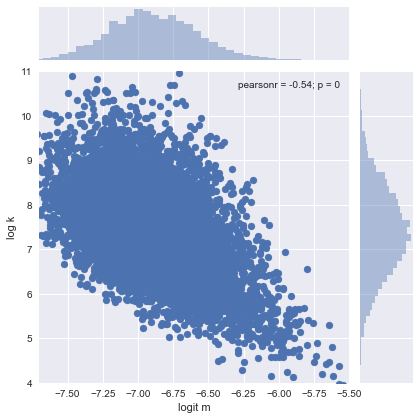

In [12]:
n_unitss = [4]
hs = (tt.nnet.sigmoid, tt.nnet.sigmoid)
gs = (tt.nnet.softplus, tt.exp)
iaf1 = SimpleMadeIAF(n_unitss, hs, gs, rev_order=False, random_seed=0)
iaf2 = SimpleMadeIAF(n_unitss, hs, gs, rev_order=True, random_seed=1)
nfs = [iaf2, iaf1]

with get_model() as model:
    x = model.basic_RVs[1]
    vparams = pm.variational.advi_minibatch(n=10000, optimizer=adam, minibatch_tensors=[], minibatches=[], 
                                            observed_RVs=OrderedDict({x: 1}), local_RVs=OrderedDict(), 
                                            global_NFs=nfs)
    trace = pm.variational.sample_vp(vparams, 10000, global_NFs=nfs)
    
plot_samples(trace)

## References
* Rezende, D. J., & Mohamed, S. (2015). Variational inference with normalizing flows. arXiv preprint arXiv:1505.05770.
* Salimans, T., Kingma, D. P., & Welling, M. (2015). Markov chain Monte Carlo and variational inference: Bridging the gap. In International Conference on Machine Learning (pp. 1218-1226).
* Albert, J. (2009). Bayesian computation with R. Springer Science & Business Media.
* Kingma, D. P., Salimans, T., & Welling, M. (2016). Improving variational inference with inverse autoregressive flow. arXiv preprint arXiv:1606.04934.
* Germain, M., Gregor, K., Murray, I., & Larochelle, H. (2015, February). Made: masked autoencoder for distribution estimation. In International Conference on Machine Learning (pp. 881-889).